CIFAR-10 Dataset with CNN
- 32x32 color images

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import numpy as np
import pandas as pd
import seaborn as sn  # for heatmaps
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
transform = transforms.ToTensor()

In [3]:
train_data = datasets.CIFAR10(root='../Data', train=True, download=True, transform=transform)

Files already downloaded and verified


In [4]:
test_data = datasets.CIFAR10(root='../Data', train=False, download=True, transform=transform)

Files already downloaded and verified


In [5]:
train_data

Dataset CIFAR10
    Number of datapoints: 50000
    Split: train
    Root Location: ../Data
    Transforms (if any): ToTensor()
    Target Transforms (if any): None

In [6]:
test_data

Dataset CIFAR10
    Number of datapoints: 10000
    Split: test
    Root Location: ../Data
    Transforms (if any): ToTensor()
    Target Transforms (if any): None

In [7]:
torch.manual_seed(101)
train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10, shuffle=False)

In [8]:
class_names = ['plane', '  car', ' bird', '  cat', ' deer', '  dog', ' frog', 'horse', ' ship', 'truck']

In [9]:
for images,labels in train_loader: 
    break

In [10]:
labels

tensor([3, 2, 0, 4, 9, 5, 1, 2, 4, 8])

Label: [    3     2     0     4     9     5     1     2     4     8]
Class:    cat  bird plane  deer truck   dog   car  bird  deer  ship


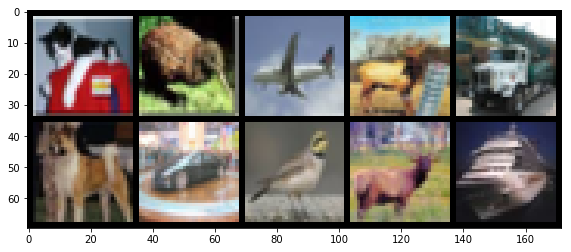

In [11]:
np.set_printoptions(formatter=dict(int=lambda x: f'{x:5}')) # to widen the printed array

# Print the labels
print('Label:', labels.numpy())
print('Class: ', *np.array([class_names[i] for i in labels]))

im = make_grid(images, nrow = 5)
plt.figure(figsize = (10, 4))
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)))

In [12]:
class ConvolutionalNetwork (nn.Module):
    
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3,6,5,1)
        self.conv2 = nn.Conv2d(6,16,3,1) #common to reduce the size of kernnel
        self.fc1 = nn.Linear(6*6*16, 120)
        self.fc2 = nn.Linear(120,84)
        self.fc3 = nn.Linear(84,10)
        
    def forward (self, X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X,2,2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X,2,2)
        X = X.view(-1, 6*6*16)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        return F.log_softmax(X, dim=1)

In [13]:
torch.manual_seed(101)
model = ConvolutionalNetwork()
model

ConvolutionalNetwork(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=576, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [14]:
for param in model.parameters():
    print(param.numel())

450
6
864
16
69120
120
10080
84
840
10


In [15]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [16]:
import time
start_time = time.time()

epochs = 10
train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
    
    # Run the training batches
    for b, (X_train, y_train) in enumerate(train_loader):
        b+=1
        
        # Apply the model
        y_pred = model(X_train)
        loss = criterion(y_pred, y_train)
 
        # Tally the number of correct predictions
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr
        
        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Print interim results
        if b%1000 == 0:
            print(f'epoch: {i:2}  batch: {b:4} [{10*b:6}/50000]  loss: {loss.item():10.8f}  \
accuracy: {trn_corr.item()*100/(10*b):7.3f}%')
        
    train_losses.append(loss)
    train_correct.append(trn_corr)
        
    # Run the testing batches
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):

            # Apply the model
            y_val = model(X_test)

            # Tally the number of correct predictions
            predicted = torch.max(y_val.data, 1)[1] 
            tst_corr += (predicted == y_test).sum()
            
    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)
        
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed       

epoch:  0  batch: 1000 [ 10000/50000]  loss: 1.67355442  accuracy:  26.710%
epoch:  0  batch: 2000 [ 20000/50000]  loss: 1.45116973  accuracy:  32.230%
epoch:  0  batch: 3000 [ 30000/50000]  loss: 1.87373388  accuracy:  35.730%
epoch:  0  batch: 4000 [ 40000/50000]  loss: 1.68802071  accuracy:  38.182%
epoch:  0  batch: 5000 [ 50000/50000]  loss: 2.21869493  accuracy:  39.974%
epoch:  1  batch: 1000 [ 10000/50000]  loss: 1.20014679  accuracy:  48.960%
epoch:  1  batch: 2000 [ 20000/50000]  loss: 1.56332612  accuracy:  49.580%
epoch:  1  batch: 3000 [ 30000/50000]  loss: 0.76813745  accuracy:  49.997%
epoch:  1  batch: 4000 [ 40000/50000]  loss: 1.09740090  accuracy:  50.542%
epoch:  1  batch: 5000 [ 50000/50000]  loss: 1.69403386  accuracy:  51.040%


KeyboardInterrupt: 

In [ ]:
torch.save(model.state_dict(),'myCIFARmodel.pt')

In [ ]:
plt.plot(train_losses, label='training loss')
plt.plot(test_losses, label='validation loss')
plt.title('Loss at the end of each epoch')
plt.legend();

In [ ]:
plt.plot([t/500 for t in train_correct], label='training accuracy')
plt.plot([t/100 for t in test_correct], label='validation accuracy')
plt.title('Accuracy at the end of each epoch')
plt.legend();

In [ ]:
print(test_correct)

In [ ]:
num_c = test_correct[-1].item()

In [ ]:
num_c*100 /10000

Not great but better than a 10% random chance of guessing

In [ ]:
# Create a loader for the entire the test set
test_load_all = DataLoader(test_data, batch_size=10000, shuffle=False)

with torch.no_grad():
    correct = 0
    for X_test, y_test in test_load_all:
        y_val = model(X_test)
        predicted = torch.max(y_val,1)[1]
        correct += (predicted == y_test).sum()

arr = confusion_matrix(y_test.view(-1), predicted.view(-1))
df_cm = pd.DataFrame(arr, class_names, class_names)
plt.figure(figsize = (9,6))
sn.heatmap(df_cm, annot=True, fmt="d", cmap='BuGn')
plt.xlabel("prediction")
plt.ylabel("label (ground truth)")
plt.show();

Want diagonal to be darker, that would mean more accurate prediction
- we can see trucks are often misclassified as cars
- dogs are often misclassified as cats

Now with real image data

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [14]:
import os
from PIL import Image
from IPython.display import display

# Filter harmless warnings
import warnings
warnings.filterwarnings("ignore")

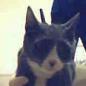

In [15]:
#check full file path
with Image.open('../Data/CATS_DOGS/CATS_DOGS/test/CAT/10107.jpg') as im:
    display(im)

In [16]:
path = "../Data/CATS_DOGS/CATS_DOGS/"
img_names = []

for folder, subfolders, filenames in os.walk(path):
    for img in filenames:
        img_names.append(folder+'/'+img)

In [17]:
len(img_names)

24994

In [18]:
img_sizes = []
rejected = []

for item in img_names:
    try:
        with Image.open(item) as img:
            img_sizes.append(img.size)
    except:
        rejected.append(item)

In [19]:
print(len(img_sizes))
print(len(rejected))

24994
0


In [20]:
df = pd.DataFrame(img_sizes)

In [21]:
df[0].describe() #width

count    24994.000000
mean       404.493518
std        108.941802
min         42.000000
25%        323.000000
50%        448.000000
75%        500.000000
max        500.000000
Name: 0, dtype: float64

In [22]:
df[1].describe() #height

count    24994.000000
mean       361.037129
std         96.936811
min         33.000000
25%        302.000000
50%        375.000000
75%        421.000000
max        500.000000
Name: 1, dtype: float64

In [23]:
dog = Image.open('../Data/CATS_DOGS/CATS_DOGS/train/DOG/14.jpg')

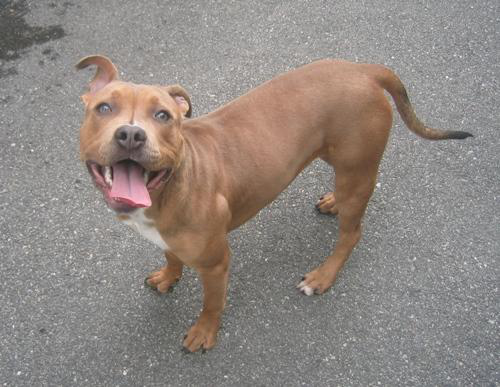

In [24]:
display(dog)

In [25]:
dog.size

(500, 387)

In [26]:
dog.getpixel((0,0)) #0 - 255

(90, 95, 98)

In [27]:
transform = transforms.Compose([
    transforms.ToTensor()
])
im = transform(dog)
print(type(im))
print(im.shape)

<class 'torch.Tensor'>
torch.Size([3, 387, 500])


In [ ]:
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)))

In [ ]:
im

values are standardized between 0 and 1 now

In [ ]:
np.array((90, 95, 98))/ 255

they got divided by the max value

torch.Size([3, 224, 289])


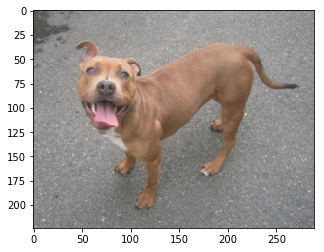

In [28]:
#Transform to resize the image
transform = transforms.Compose([
    transforms.Resize(224),  #could pass in a touple to affect both edges
    transforms.ToTensor()
])
im = transform(dog)
print(im.shape)
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));

torch.Size([3, 250, 250])


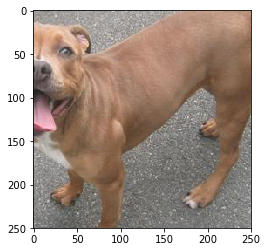

In [29]:
#Center Crop (without resizing first)
transform = transforms.Compose([
    transforms.CenterCrop(250),
    transforms.ToTensor()
])
im = transform(dog)
print(im.shape)
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));

torch.Size([3, 250, 250])


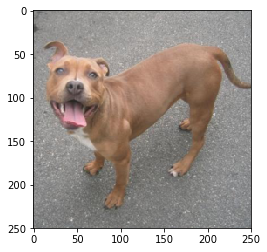

In [30]:
#Center Crop (resizing first)
transform = transforms.Compose([
    transforms.Resize(250),
    transforms.CenterCrop(250),
    transforms.ToTensor()
])
im = transform(dog)
print(im.shape)
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));

torch.Size([3, 387, 500])


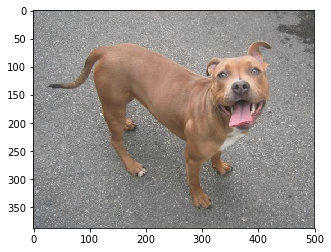

In [31]:
#Random horizontal flip
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=1), #100% probability it will be flipped
    transforms.ToTensor()
])
im = transform(dog)
print(im.shape)
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));

torch.Size([3, 387, 500])


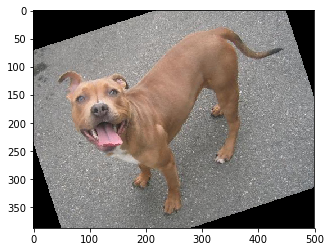

In [32]:
#Random rotation
transform = transforms.Compose([
    transforms.RandomRotation(30), #randomlly rotates between +-30 degrees
    transforms.ToTensor()
])
im = transform(dog)
print(im.shape)
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));

torch.Size([3, 224, 224])


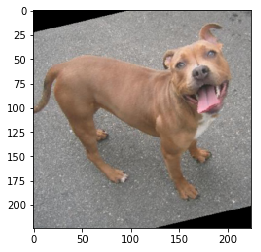

In [33]:
#a bunch put together
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=1),  # normally we'd set p=0.5
    transforms.RandomRotation(30),
    transforms.Resize(224),
    transforms.CenterCrop(224), 
    transforms.ToTensor()
])
im = transform(dog)
print(im.shape)
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));

Normalization

In [34]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean= [0.485, 0.456, 0.406], std= [0.229, 0.224, 0.225])
])
#the mean and std values are proven to be best for pretrained networks
#one number for each color channel

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 387, 500])


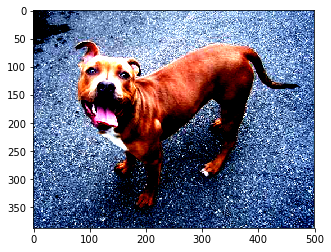

In [35]:
im = transform(dog)
print(im.shape)
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));

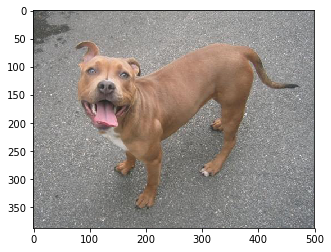

In [36]:
#to de-normalize
inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)
im_inv = inv_normalize(im)
plt.figure(figsize=(12,4))
plt.imshow(np.transpose(im_inv.numpy(), (1, 2, 0)));

CNN with Custom Images

In [37]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models # add models to the list
from torchvision.utils import make_grid
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

In [38]:
train_transform = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(),
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
])

In [39]:
test_transform = transforms.Compose([
    #dont need the random rotation or horizontal flips
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
])

In [40]:
root = '../Data/CATS_DOGS/CATS_DOGS'

train_data = datasets.ImageFolder(os.path.join(root, 'train'), transform = train_transform)

test_data = datasets.ImageFolder(os.path.join(root, 'test'), transform = test_transform)

torch.manual_seed(42)

train_loader = DataLoader(train_data, batch_size = 10, shuffle = True)
test_loader = DataLoader(test_data, batch_size  = 10)

class_names = train_data.classes


In [41]:
class_names

['CAT', 'DOG']

In [42]:
len(train_data)

18743

In [43]:
len(test_data)

6251

In [44]:
for images, labels in train_loader:
    break

In [45]:
images.shape

torch.Size([10, 3, 224, 224])

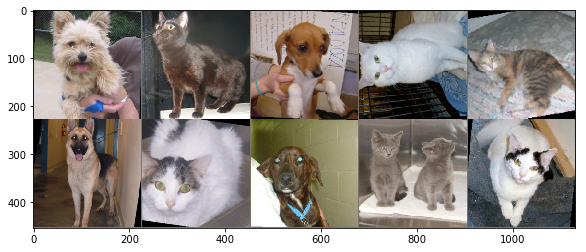

In [46]:
im = make_grid(images, nrow = 5)

inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)
im_inv = inv_normalize(im)

plt.figure(figsize=(12,4))
plt.imshow(np.transpose(im_inv.numpy(), (1, 2, 0)));

In [47]:
# define model
class ConvolutionalNetwork(nn.Module):
    
    def __init__(self):
        
        super().__init__()
        self.conv1 = nn.Conv2d(3,6,3,1)
        self.conv2 = nn.Conv2d(6,16,3,1)
        self.fc1 = nn.Linear(54*54*16, 120) # (((224-2)/2)-2)/2
        self.fc2 = nn.Linear(120,84)
        self.fc3 = nn.Linear(84,2)
        
    def forward (self, X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X,2,2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X,2,2)
        X = X.view(-1,54*54*16) #flatten out
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        
        return F.log_softmax(X, dim=1)

In [48]:
torch.manual_seed(101)
CNNmodel = ConvolutionalNetwork()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(CNNmodel.parameters(), lr=0.001)

In [49]:
CNNmodel

ConvolutionalNetwork(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=46656, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=2, bias=True)
)

In [50]:
for p in CNNmodel.parameters():
    print(p.numel())

162
6
864
16
5598720
120
10080
84
168
2


In [39]:
import time
start_time = time.time()


epochs = 3

#Limits number of batches (not necessary but makes quicker)
max_trn_batch = 800 #batch 10 images so total is 8000 images max
max_tst_batch = 300 #batch 10 images so total is 3000 images max

train_losses = []
test_losses = []
tain_correct =[]
test_correct =[]

for i in range(epochs):
    
    trn_correct = 0
    tst_correct = 0
    
    for b, (X_train, y_train) in enumerate(train_loader):
        
        #optional limit number of batches
        if b == max_trn_batch:
            break
            
        b += 1
        
        y_pred = CNNmodel(X_train)
        loss = criterion(y_pred, y_train)
        
        # Tally the number of correct predictions
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr
        
        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if b%200 == 0:
            print(f'Epoch {i}  LOSS: {loss.item()}')
            
    train_losses.append(loss)
    train_correct.append(trn_corr)
    
    #test set
    
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):
            
            #Optional
            if b == max_tst_batch:
                break
                
            y_val = CNNmodel(X_test)
            
            predicted = torch.max(y_pred.data, 1)[1]
            batch_corr = (predicted == y_test).sum()
            tst_correct = tst_corr + batch_corr
            
    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)
    
total_time = time.time() - start_time

print(f'Total Time: {total_time/60} minutes')

Epoch 0  LOSS: 0.88001948595047
Epoch 0  LOSS: 0.3501809239387512
Epoch 0  LOSS: 0.4621175229549408
Epoch 0  LOSS: 0.3972364068031311
Epoch 1  LOSS: 0.5676281452178955
Epoch 1  LOSS: 0.6470796465873718
Epoch 1  LOSS: 0.4985305666923523
Epoch 1  LOSS: 0.3653019666671753
Epoch 2  LOSS: 0.4155416488647461
Epoch 2  LOSS: 0.365901380777359
Epoch 2  LOSS: 0.6380245685577393
Epoch 2  LOSS: 0.5713337659835815
Total Time: 12.781357232729594 minutes


In [41]:
torch.save(CNNmodel.state_dict(),'my3epochmodel.pt')

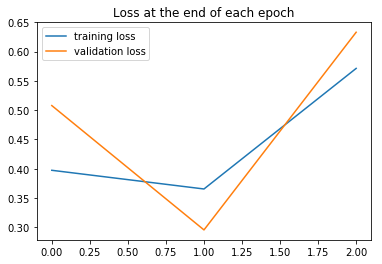

In [42]:
plt.plot(train_losses, label='training loss')
plt.plot(test_losses, label='validation loss')
plt.title('Loss at the end of each epoch')
plt.legend();

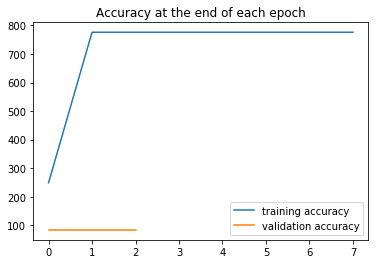

In [43]:
plt.plot([t/80 for t in train_correct], label='training accuracy')
plt.plot([t/30 for t in test_correct], label='validation accuracy')
plt.title('Accuracy at the end of each epoch')
plt.legend();

In [44]:
print(test_correct)
print(f'Test accuracy: {test_correct[-1].item()*100/3000:.3f}%')

[tensor(2543), tensor(2543), tensor(2543)]
Test accuracy: 84.767%


Downloading and using pretrained models
- expect input images normalized in the same way
    - 3 channel RGB images
    - shape 3 x H x W
    - at least 224 pixels
    - loaded in range [0,1]
    - noramlized using certain mean and sd values
        - mean = [-0.485, -0.456, -0.406]
        - std = [0.229, 0.224, 0.225]
      
Using AlexNet for this lecture

In [4]:
AlexNetmodel = models.alexnet(pretrained = True)

In [5]:
AlexNetmodel

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): ReLU(inplace)
    (3): Dropout(p

In [6]:
#freeze pretrained weights and biases
for param in AlexNetmodel.parameters():
    param.requires_grad = False

In [7]:
torch.manual_seed(42)
AlexNetmodel.classifier = nn.Sequential(nn.Linear(9216, 1024),
                                 nn.ReLU(),
                                 nn.Dropout(0.4),
                                 nn.Linear(1024, 2),
                                 nn.LogSoftmax(dim=1))

In [8]:
AlexNetmodel

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Linear(in_features=9216, out_features=1024, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.4)
    (3): Linear(in_featur

In [9]:
for param in AlexNetmodel.parameters():
    print(param.numel())

23232
64
307200
192
663552
384
884736
256
589824
256
9437184
1024
2048
2


In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(AlexNetmodel.classifier.parameters(), lr=0.001)

In [51]:
#only training the fully connected layers
import time
start_time = time.time()

epochs = 1

max_trn_batch = 800
max_tst_batch = 300

train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
    
    # Run the training batches
    for b, (X_train, y_train) in enumerate(train_loader):
        if b == max_trn_batch:
            break
        b+=1
        
        # Apply the model
        y_pred = AlexNetmodel(X_train)
        loss = criterion(y_pred, y_train)
 
        # Tally the number of correct predictions
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr
        
        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print interim results
        if b%200 == 0:
            print(f'epoch: {i:2}  batch: {b:4} [{10*b:6}/8000]  loss: {loss.item():10.8f}  \
accuracy: {trn_corr.item()*100/(10*b):7.3f}%')

    train_losses.append(loss)
    train_correct.append(trn_corr)

    # Run the testing batches
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):
            if b == max_tst_batch:
                break

            # Apply the model
            y_val = AlexNetmodel(X_test)

            # Tally the number of correct predictions
            predicted = torch.max(y_val.data, 1)[1] 
            tst_corr += (predicted == y_test).sum()

    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)

print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed

epoch:  0  batch:  200 [  2000/8000]  loss: 1.06754518  accuracy:  42.600%
epoch:  0  batch:  400 [  4000/8000]  loss: 1.02062106  accuracy:  41.075%
epoch:  0  batch:  600 [  6000/8000]  loss: 1.07075238  accuracy:  41.183%
epoch:  0  batch:  800 [  8000/8000]  loss: 0.65642130  accuracy:  41.000%

Duration: 310 seconds


In [52]:
print(test_correct[-1].item()/3000)

0.3566666666666667


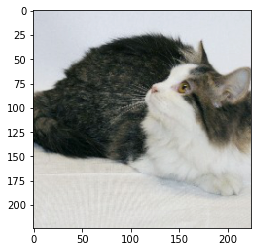

In [53]:
image_index = 2019

im = inv_normalize(test_data[image_index][0])
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)))

In [55]:
CNNmodel.eval()
with torch.no_grad():
    new_pred = CNNmodel(test_data[image_index][0].view(1,3,224,224)).argmax()
print(f'Predicted value: {new_pred.item()} {class_names[new_pred.item()]}')

Predicted value: 0 CAT


In [56]:
AlexNetmodel.eval()
with torch.no_grad():
    new_pred = AlexNetmodel(test_data[image_index][0].view(1,3,224,224)).argmax()
print(f'Predicted value: {new_pred.item()} {class_names[new_pred.item()]}')

Predicted value: 0 CAT
